## Trabajo Práctico N°1

*Introducción*

Analizar el dataset con datos del primer semestre del 2017 de la inmobiliaria properatti.
Este primer paso deberá servir para poder realizar modelos de predicción utilizando regresiones.

*Objetivos:*


1.- Efectuar una limpieza del dataset provisto. Particularmente, deberá diseñar estrategias para lidiar con los datos perdidos en ciertas variables.

2-  Realizar un análisis descriptivo de las principales variables.

3.- Crear nuevas columnas a partir de las características dadas que puedan tener valor predictivo.


## Inicio
**Importación de librerías**<br>

In [1]:
#Importo las librerias que deseo usar
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns ; sns.set(color_codes=True)
import numpy as np
%matplotlib inline

Definición de algunas funciones y parámetros a utilizar en la notebook. Esto nos permitirá aplicar distintos tipos de implementaciones al modelo para probar mejor la configuracion.

In [2]:
# Permite calcular la superficie por cantidad de ambientes, para darle un peso correcto a los ambientes.
# Este valor no se utiliza si UTILIZAR_ROOMS es False
CALCULAR_SUPERFICIE_POR_AMBIENTE = True

# Permite indicar si utilizamos el campo rooms para nuestro modelo o no.
# Con True mejora el score r2
UTILIZAR_ROOMS = True

# indica si se calcula la superficie por cada ubicación con las dummies.
PLACE_X_SURFACE = True

# Indica si la superficie debe ser calculada por property type en las dummies de Property Type
PROPERTY_TYPE_X_SURFACE = True

# Indica si elimino los outliers de precios del dataset
ELIMINAR_OUTLIER_PRECIOS = True

# Indica que se deben eliminar las superficies que tienen un valor menor o igual a cero
ELIMINAR_SUPERFICIES_EN_CERO_Y_NULL = False

# Indica que se deben eliminar las superficies que son outliers
ELIMINAR_OUTLIER_SUPERFICIES = True

# Indica si se deben eliminar los registros duplicados
ELIMINAR_DUPLICADOS = True

# Si uso precio o no como variable a predecir si es false uso precio_usd_por_m2
PRECIO = True

# Identifica el campo a utilizar como superficie
CAMPO_SUPERFICIE = 'total_m2'

**Datos del dataframe**<br>
Esta función me ayuda a ver como esta constituido el dataframe mostrandolo de una manera más 
didáctica. Me muestra la cantidad de registros,cuantos son nulos, cuantos no nulos, su porcentaje y el tipo de datos

In [3]:
def datos_df(df):
        
    # Cantidad total de registros
    cant_registros = len(df)

    # Creo un dataframe para mostrar la estructura del set de datos

    valores_df = pd.DataFrame(columns=['No Nulos','Nulos','% Nulos','Tipo'])

    # Por cada columna
    for columna in df.columns:
        
        # Cantidad de Valores nulos
        val_no_null = df[columna].notnull().sum()
        
        # Cantidad de Valores nulos
        val_null = df[columna].isnull().sum()
        
        # Porcentaje de Valores Nulos en el dataset
        porcentaje_null = val_null / cant_registros * 100
        
        # El tipo de dato de la columna
        tipo_dato = df[columna].dtype
        
        # Agrego la fila al dataframe
        valores_df.loc[columna] = [val_no_null,val_null, porcentaje_null, tipo_dato]
    
    # Ordeno los valores por % de nulos de menor a mayor
    return valores_df.sort_values(by='% Nulos', ascending=True)

Esta función parsea un registro y devuelve una lista con todas las palabras de un registro en una lista
Sirve para explorar la información dentro de la descripción y sacar datos útiles. Como por ejemplo las habitaciones, metros cuadrados, amenities, etc..

In [4]:
def devuelve_palabras(registro):
    if isinstance(registro, str):
        return [ registro.split()[i] + ' ' + registro.split()[1+i]  for i, palabra in enumerate(registro.split()) if palabra.isnumeric() and i <len(registro.split())-1]
    else:
        return 0

Imputo los valores null con una bandera (flag)
Creamos una función que nos imputa a una columna, el valor indicado y crea una nueva columna que indica si el registro fue imputado. Esto para llevar un control de lo que se va haciendo.

In [5]:
def imputo_null(col_name,df, value, create_flag = True):
    "Imputa los valores NaN con el valor de value y crea una columna que indica si al registro" 
    "se le imputo un valor o no"
    
    if (create_flag):
        # Creamos el nombre de la columna FLAG
        flag_col = col_name + '_was_nan'
    
        # Creamos la columna con los valores true o false donde corresponda
        df[flag_col] = df[col_name].isnull().astype(int)
    
    # Asignamos 0 a los registros que son null
    df.loc[df[col_name].isnull(),col_name] = value

Cambio valores de string dentro de un dataset. Le paso el valor a buscar y reemplazar y el nombre de la columna y el dataframe.

In [6]:
#Todo antes lo paso a string para evitar problemas
def cambio_valor(columna,valor_buscado,reemplazo,df):
#primero calculo en numero de la columna    
    count=0
    for col in df.columns:
        if col==columna:
            numero_col=count
        count=count+1
    
    count=0
    countaux=0
    for palabra in df1[CAMPO_SUPERFICIE].astype(str):
        if palabra.find(valor_buscado)!=-1:
            numero_fil=count
            df.iloc[numero_fil,numero_col]=palabra.replace(valor_buscado,reemplazo)
            countaux=countaux+1
        count=count+1
    return 'se reemplazaron '+ str(countaux) + ' valores'

## Importo el dataset

In [7]:
#importo el archivo de properati
properatti = pd.read_csv("properatti.csv")

1. Realizo un primer análisis viendo la estructura del dataframe con la función **datos_df**
    + Tomo las columnas que me interesan para este primer análisis según lo que indica el enunciado.
    + Luego cambio el nombre de las columnas para hacerlo más didactico.

In [8]:
datos_df(properatti)

,No Nulos,Nulos,% Nulos,Tipo
Unnamed: 0,121220,0,0.000000,int64
operation,121220,0,0.000000,object
property_type,121220,0,0.000000,object
place_with_parent_names,121220,0,0.000000,object
country_name,121220,0,0.000000,object
state_name,121220,0,0.000000,object
properati_url,121220,0,0.000000,object
title,121220,0,0.000000,object
description,121218,2,0.001650,object
place_name,121197,23,0.018974,object


In [9]:
#tomo solo las columnas que podrían llegar a darme ciertas features interesentas para el análisis

df=pd.DataFrame(properatti,columns=['property_type','place_name','place_with_parent_names','state_name','lat','lon','price','currency','price_aprox_local_currency','price_aprox_usd','surface_total_in_m2','surface_covered_in_m2','price_usd_per_m2','price_per_m2','floor','rooms','expenses','description','title'])

#Ahora cambio el nombre de los campos para hacerlo más didactico

df.columns=['tipo_propiedad','localidad_barrio','ubicacion_completa','provincia_distrito','lat','lon','precio','moneda','precio_aprox_ars','precio_aprox_usd','total_m2','m2_cubiertos','precio_usd_por_m2','precio_por_m2','piso','habitaciones','expensas','descripcion','titulo']

#primer forma del dataset se lo asigno a df1
df1=df


## Observación de registros iniciales
Observamos los primeros registros para entender como están representados los datos.

In [10]:
df1.head()

,tipo_propiedad,localidad_barrio,ubicacion_completa,provincia_distrito,lat,lon,precio,moneda,precio_aprox_ars,precio_aprox_usd,total_m2,m2_cubiertos,precio_usd_por_m2,precio_por_m2,piso,habitaciones,expensas,descripcion,titulo
0,PH,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,-34.661824,-58.508839,62000.0,USD,1093959.0,62000.0,55.0,40.0,1127.272727,1550.000000,NaN,NaN,NaN,"2 AMBIENTES TIPO CASA PLANTA BAJA POR PASILLO,...",2 AMB TIPO CASA SIN EXPENSAS EN PB
1,apartment,La Plata,|Argentina|Bs.As. G.B.A. Zona Sur|La Plata|,Bs.As. G.B.A. Zona Sur,-34.903883,-57.964330,150000.0,USD,2646675.0,150000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Venta de departamento en décimo piso al frente...,VENTA Depto 2 dorm. a estrenar 7 e/ 36 y 37 ...
2,apartment,Mataderos,|Argentina|Capital Federal|Mataderos|,Capital Federal,-34.652262,-58.522982,72000.0,USD,1270404.0,72000.0,55.0,55.0,1309.090909,1309.090909,NaN,NaN,NaN,2 AMBIENTES 3ER PISO LATERAL LIVING COMEDOR AM...,2 AMB 3ER PISO CON ASCENSOR APTO CREDITO
3,PH,Liniers,|Argentina|Capital Federal|Liniers|,Capital Federal,-34.647797,-58.516424,95000.0,USD,1676227.5,95000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PH 3 ambientes con patio. Hay 3 deptos en lote...,PH 3 amb. cfte. reciclado
4,apartment,Centro,|Argentina|Buenos Aires Costa Atlántica|Mar de...,Buenos Aires Costa Atlántica,-38.002626,-57.549447,64000.0,USD,1129248.0,64000.0,35.0,35.0,1828.571429,1828.571429,NaN,NaN,NaN,DEPARTAMENTO CON FANTÁSTICA ILUMINACIÓN NATURA...,DEPTO 2 AMB AL CONTRAFRENTE ZONA CENTRO/PLAZA ...


***Aclaración sobre los nombres del los campos***<br>
Por el tamaño del dataset y como herramienta de exploración se utilizo el excel. Esto, entendiendo que el trabajo de análisis puede realizarse con cualquier herramienta que se ajuste mejor a dicho fin, en base al conocimiento del alumno.

En función de lo anterior se pudo ver:
1. Mejorar el nombre de los campos
2. Se define el campo **localidad_barrio** porque según la estructura ese campo solo posee los valores referentes a localidades de grandes Distritos o barrios dentro de las localidades por ejemplo Capital Federal.
3. Se define el campo **provincia_distrito** porque según la estructura ese campo solo posee los valores referentes a grandes distritos/departamentos y provincias.

## Comienzo con algo de análisis de datos
Veo como están correlacionados las variables 
***Posibles features que definen el precio / precio por m2 de una propiedad***

**tipo_propiedad ; localidad_barrio ; provincia_distrito ; total_m2 ; superficie_cubierta_m2 ; habitaciones ; piso; también otras características de la propiedad como servicios asociados, habitaciones, amenities, etc..**

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]), <a list of 6 Text xticklabel objects>)

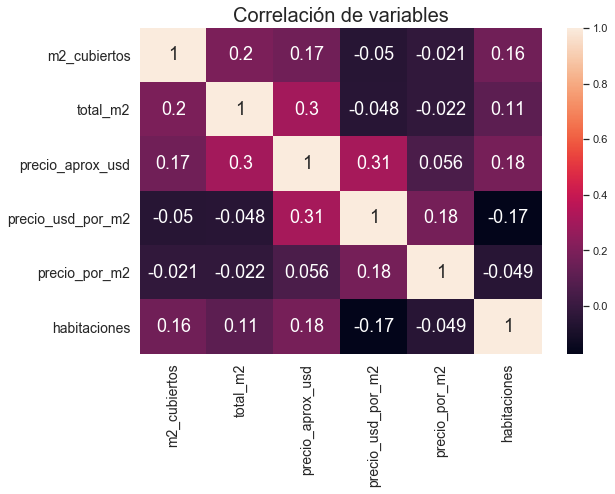

In [11]:
plt.figure(figsize=(9,6))
sns.heatmap(df1[['m2_cubiertos','total_m2','precio_aprox_usd','precio_usd_por_m2','precio_por_m2','habitaciones']].corr(), annot=True, annot_kws={"size": 18})
plt.title('Correlación de variables', fontsize=20)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

## Comenzando con algo de limpieza

1. Según el análisis de nulos y teniendo en cuenta que una feature importante es la ubicación, voy a tratar de llenar los 23 nulos de **localidad_barrio** tratando de sacar dicho valor de ubicacion_completa o de algún campo texto como **descripcion o título**
2. Voy pasar todo el precio de las propiedades a dólares. Para tener un referencia en moneda dura. Por el análisis en excel realizado y sumado a la puesta en común del TP se define que el **precio_aprox_usd** es el que mejor calidad posee.
3. Voy a analizar los valores de precios por metro cuadrado. Y para este caso solo voy a usar el campo **precio_usd_por_m2** completando los faltatantes usando el campo **precio_por_m2**.



In [12]:
#Veo si puedo completar los valores nulos de localidad_barrio usando el campo ubicación_completa
df1.loc[(df1.localidad_barrio.isnull()), 'ubicacion_completa'].head()

6489     |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
10201    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
11451    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
14839    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
18622    |Argentina|Bs.As. G.B.A. Zona Norte|Tigre||
Name: ubicacion_completa, dtype: object

Se puede ver que no dispongo de ese valor voy a utilizar los campos **título** y **descripción**

Luego de analizar el campo **titulo** se puede ver que el nombre del barrio corresponde a Barrio Privado Santa Maria para la mayoría de los casos, Barrio El Palmar, Barrio Las Tipas y Barrio Privado La Alameda. 

Para poder detectar esos casos se utlizó el código comentado que esta abajo en donde se tuvieron que ver las 23 celdas del campo **titulo** y **descripcion**.

In [13]:
#Veo que información puedo sacar con titulo y descripcion para los casos nulos de localidad_barrio
#df1.loc[df1.localidad_barrio.isnull(),['titulo','descripcion']]

#recupero el DataFrame y veo en titulo lo que contenga el nombre del Barrio SANTA MARIA solo recupero 15 y son 23
#df1.loc[(df1['titulo'].str.\
#contains('SANTA MARIA|Santa Ma', case=False,regex=True)) & df1.localidad_barrio.isnull(),['localidad_barrio','ubicacion_completa','descripcion','titulo']]

#agrego en localidad barrio Santa María- es un barrio cerrado según lo buscado en internet
df1.loc[(df1['titulo'].str.\
contains('SANTA MARIA|Santa Ma', case=False)) & df1.localidad_barrio.isnull(),'localidad_barrio']='Barrio Privado Santa Maria'

#ahora completo a mano usando el indice, con la función de arriba saque los nulos que me quedan
df1.iloc[38856,1]="Barrio Privado Santa Maria"
df1.iloc[45970,1]="Barrio El Palmar"
df1.iloc[53130,1]="Barrio Privado Santa Maria"
df1.iloc[62411,1]="Barrio Las Tipas"
df1.iloc[62413,1]="Barrio Privado Santa Maria"
df1.iloc[18622,1]="Barrio Privado Santa Maria"
df1.iloc[46642,1]="Barrio Privado Santa Maria"
df1.iloc[63849,1]="Barrio Privado La Alameda"

Elimino la columna ubicacion_completa porque es redundantes

In [14]:
df1 = df1.drop('ubicacion_completa', axis=1)

## Superficie
Analizamos las variables de superficie (**total_m2** y **m2_cubierto**) y su relación con el precio (**precio**) para identificar si el precio está basado en la superficie cubierta o en la superficie total.

## Análisis de precio vs total de m2 y m2 cubiertos
Identificamos que el precio de las propiedades es por m2 totales (**total_m2**), calculando el precio / precio por metro cuadrado. Esto nos devuelve un valor que cuando lo comparamos contra superficie total vemos que es exactamente el mismo, por lo que encontramos que hay una relación directa de precio total contra superficie total.

In [15]:
#utilizo el campo precio aprox en usd porque el campo precio tiene ruido. Esto lo pudimos ver 
#en la revisión del tp1. Reemplazo el precio por precio aprox

df1["precio"]=df1["precio_aprox_usd"]
df1 = df1.drop('precio_aprox_usd', axis=1)


Text(0.5, 1.0, 'Relación de Precio vs Superficie (total y cubierta)')

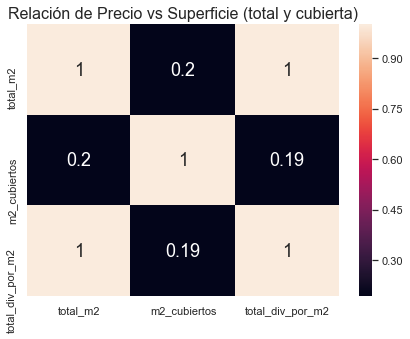

In [16]:
df_tmp = df1[['precio','precio_usd_por_m2','total_m2','m2_cubiertos']].copy()
df_tmp['total_div_por_m2'] = df_tmp['precio'] / df_tmp['precio_usd_por_m2']

plt.figure(figsize=(7,5))
sns.heatmap(df_tmp[['total_m2','m2_cubiertos','total_div_por_m2']].corr(), annot=True, annot_kws={"size": 18})
plt.title('Relación de Precio vs Superficie (total y cubierta)', fontsize=16)

Los datos vistos anteriormente me permiten luego calcular el total_m2 para los casos en donde no tengo valor usando el precio y el precio_usd_por_m2

In [17]:
#Los casos en donde precio_usd_por_m2== precio agrego null al precio_usd_por_m2 y al precio_por_m2 
#para luego ver si lo puedo llenar con la media
df1.loc[(df1.precio_usd_por_m2==df1.precio),'precio_usd_por_m2']= np.nan
df1.loc[(df1.precio_por_m2==df1.precio),'precio_por_m2']= np.nan

### Calculamos el total en m2
Calculamos la superficie total basada en el precio / el precio por m2 en dolares. Para los casos en donde este valor es null o cero

In [18]:
# SOLO CALCULAMOS SI NO SE PIDE ELIMINAR A LOS NULOS Y 0. SINO LOS ELIMINAMOS COMPLETAMENTE.

if ELIMINAR_SUPERFICIES_EN_CERO_Y_NULL == False:
    # Creamos un flag que indica si la superficie fue calculada
    df1['superficie_era_null'] = 0

    # Columnas de Dolares que no sean null pero que la superficie sea null
    df_tmp = df1.loc[
        (df1['precio'].notnull()) & 
        (df1['precio_usd_por_m2'].notnull()) &
        ((df1[CAMPO_SUPERFICIE].isnull()) | (df1[CAMPO_SUPERFICIE] == 0)) # Que sea nulo o Cero
    ].copy()

    # Calculamos la superficie
    df_tmp['superficie'] = df_tmp['precio'] / df_tmp['precio_usd_por_m2']
    
    
    # Asigno la cuperficie calculada al dataframe original
    df1.loc[
        (df1['precio'].notnull()) & 
        (df1['precio_usd_por_m2'].notnull()) &
        (df1[CAMPO_SUPERFICIE].isnull()), [CAMPO_SUPERFICIE, 'superficie_era_null']] = [df_tmp['superficie'], 1]

else:
    df1 = df1.loc[(dataframe[CAMPO_SUPERFICIE].notnull()) | (df1[CAMPO_SUPERFICIE] > 0)]

### Obtención de datos desde Descripción y Titulo

Intentamos obtener superficies de la descripción y del titulo

**Completo el total_m2, los ambientes y habitaciones**
1. Armo un DataFrame con la info necesaria de los campos descripción y título.
2. Completo el total_m2 para los casos nulos
3. Completo las habitaciones nulas.Tomando como criterio que habitaciones==ambientes==dormitorios 

Completo los faltantes buscando con una expresión regular todo lo que tenga algo relacionado con m2

In [19]:
# Solo obtengo de la descripcion si no las voy a borrar
if ELIMINAR_SUPERFICIES_EN_CERO_Y_NULL == False:

    #Creo la mask para obtener los registros con superficie cubierta total null o en 0
    mask = (df1[CAMPO_SUPERFICIE].isnull()) | (df1[CAMPO_SUPERFICIE] == 0)

    # Obtengo las superficies de la descripción
    tmp = df1.loc[mask,'descripcion'].str.lower().str.extract('(((\d+)|(\d+(,|\.)\d+))(\s+|())mts|((\d+)|(\d+(,|\.)\d+))(\s+|())m2)', expand=False)

    #Establezco los valores al dataframe
    df1.loc[mask,[CAMPO_SUPERFICIE]] = tmp[0].str.lower().str.replace('m2','').str.replace('mts','')
    
    # Obtengo las superficies del titulo
    tmp = df1.loc[mask,'titulo'].str.lower().str.extract('(((\d+)|(\d+(,|\.)\d+))(\s+|())mts|((\d+)|(\d+(,|\.)\d+))(\s+|())m2)', expand=False)

    #Establezco los valores al dataframe
    df1.loc[mask,[CAMPO_SUPERFICIE]] = tmp[0].str.lower().str.replace('m2','').str.replace('mts','')


In [20]:
#si quedo algun campo con una coma "," lo corrijo
cambio_valor(CAMPO_SUPERFICIE,',','.',df1)

'se reemplazaron 6 valores'

In [21]:
#Elimino los que no pude completar
df1 = df1.loc[df1[CAMPO_SUPERFICIE].notnull()]

### Calculamos el precio
Calculamos los precios null haciendo algo parecio al **total_m2**. **precio=total_m2*precio_usd_por_m2**

In [22]:
#df1.loc[(df1.precio.isnull()) | (df1.precio==0),'precio']=df1.loc[(df1.precio.isnull()) | (df1.precio==0),'precio_usd_por_m2'] * df1.loc[(df1.precio.isnull()) | (df1.precio==0),'total_m2']

## Habitaciones
Intentamos obtener la cantidad de ambientes de la descripcion y del titulo utilizando expresiones regulares.<br>

In [23]:
#Completo las habitaciones usando titulo y descripcion 

#mascara para solo completar los null y ceros
mask = (df1['habitaciones'].isnull()) | (df1['habitaciones'] == 0)

#Expresion regular la pongo en un DataFrame tmp. Esta expresión arma 3 grupos donde cada columna corresponde al grupo empezando

#Primero usando ambientes
tmp=df1.loc[mask,'descripcion'].str.lower().str.extract("(\d+)(\s|())amb",expand=False)

#Ahora completo el DataFrame para los casos nulos en ambientes

df1.loc[mask,'habitaciones'] = tmp[0]

#Completo los casos en donde tmp[0] es null sacando datos de titulo ahora
tmp=df1.loc[mask,'titulo'].str.lower().str.extract("(\d+)(\s|())amb",expand=False)

#Ahora completo el DataFrame para los casos nulos

df1.loc[mask,'habitaciones'] = tmp[0]

#ahora usando habitaciones
tmp=df1.loc[mask,'descripcion'].str.lower().str.extract("(\d+)(\s|())hab",expand=False)

#Ahora completo el DataFrame para los casos nulos

df1.loc[mask,'habitaciones'] = tmp[0]

#Completo los casos en donde tmp[0] es null sacando datos de titulo ahora
tmp=df1.loc[mask,'titulo'].str.lower().str.extract("(\d+)(\s|())hab",expand=False)

#Ahora completo el DataFrame para los casos nulos en ambientes
df1.loc[mask,'habitaciones'] = tmp[0]

#ahora dormitorio
tmp=df1.loc[mask,'descripcion'].str.lower().str.extract("(\d+)(\s|())dormi",expand=False)

#Ahora completo el DataFrame para los casos nulos

df1.loc[mask,'habitaciones'] = tmp[0]

#Completo los casos en donde tmp[0] es null sacando datos de titulo ahora
tmp=df1.loc[mask,'titulo'].str.lower().str.extract("(\d+)(\s|())dormi",expand=False)

#Ahora completo el DataFrame para los casos nulos en ambientes

df1.loc[mask,'habitaciones'] = tmp[0]

In [24]:
#Asigno 1 a las propiedades que en su descripción tengan la palabra monoambiente
df1.loc[(df1['habitaciones'].isnull()) & (df1['descripcion'].str.lower().str.contains('monoambiente')),'habitaciones'] = 1

df1.loc[(df1['habitaciones'].isnull()) & (df1['titulo'].str.lower().str.contains('monoambiente')),'habitaciones'] = 1

Imputamos los demas valores que no pudimos obtener de la descripción o el titulo
Imputando 1 a los valores nulos, y creando una variable flag que indica al modelo cuales fueron imputados a mano. (hab_was_nan)

In [25]:
# Imputamos 1 y creamos un flag que indica la imputación
imputo_null('habitaciones', df1, 1)

# Contamos la cantidad de habitaciones que fueron imputados
print('Se imputaron',df1.loc[df1['habitaciones_was_nan'] == True, 'habitaciones_was_nan'].count(),'registros que tenian nulos en habitaciones')

# Convertimos habitaciones a int
df1['habitaciones'] = df1['habitaciones'].astype(int)

Se imputaron 46636 registros que tenian nulos en habitaciones


### habitaciones con valor 0
Tambien encontramos ambientes con el valor 0. Le imputamos 1 y le asignamos el flag como si hubiera sido NaN

In [26]:
# Lo marcamos como si hubiera sido NaN y le asignamos el valor 1
df1.loc[df1['habitaciones'] == 0, ['habitaciones_was_nan','habitaciones']] = [1, 1]

### Imputar Media de Habitaciones
Imputamos a las habitaciones que eran nulas, la media de acuerdo a la ubicacion y tipo de propiedad.
Para esto creo un campo con la ubicacion completa que sea la concatenacion de **provincia_distrito** + **localidad_barrio**. Además esto me va a servir luego para reducir columnas.

In [27]:
# Convertimos los campos a string
df1['provincia_distrito'] = df1['provincia_distrito'].astype(str)
df1['localidad_barrio'] = df1['localidad_barrio'].astype(str)

#creo el campo con la ubicación
df1['ubicacion']=df1['provincia_distrito'] +'-'+ df1['localidad_barrio']

In [29]:
if UTILIZAR_ROOMS:
    # Obtenemos las ubicaciones
    ubicacion = df1['ubicacion'].unique()

    # por cada lugar
    for lugar in ubicacion:
    
        # Obtenemos las propiedades del lugar
        df_ubicacion = df1.loc[df1['ubicacion'] == lugar]
        
        # Obtenemos los tipos de propiedad de este lugar
        tipos = df_ubicacion['tipo_propiedad'].unique()
        
        # por cada tipo en los tipos de propiedad
        for tipo in tipos:
            
            # Obtengo la media
            media = df_ubicacion.loc[(df_ubicacion['tipo_propiedad'] == tipo) & (df_ubicacion['habitaciones_was_nan'] == 0), 'habitaciones'].mean()
    
            if (~np.isnan(media)):
                # Se la aplico a las propiedades que habitaciones era null
                df1.loc[
                    (df1['ubicacion'] == lugar)
                    & (df1['tipo_propiedad'] == tipo)
                    & (df1['habitaciones_was_nan'] == 1)
                , 'habitaciones'] = media

### M2 por habitación
Creamos una feature que identifica los m2 por habitación, para luego descartar el campo cantidad de habitaciones. Esto nos va a dar un valor con un peso mas relativo a la superficie de cada propiedad. <br>
Por último, asignamos -1 al flag que indicaba que era missing, ya que al tener 1 habitación, le da mas peso, cuando en realidad debería darle menos. Con el flag en -1 logramos bajarle el peso a los que tienen una habitación y era null

In [30]:
# Si queremos generar columna para meterlo o no a nuestro modelo luego (Ver parametros arriba de todo)
if UTILIZAR_ROOMS & CALCULAR_SUPERFICIE_POR_AMBIENTE:
    # Calculamos m2 cubiertos / cantidad de habitaciones
    df1['m2_por_habitacion'] = df1[CAMPO_SUPERFICIE].astype(float) / df1['habitaciones'].astype(int)
    # A los registros que tenian 1 en rooms_was_nan le asignamos -1 para bajarle el peso 
    df1.loc[df1['habitaciones_was_nan'] == 1, 'habitaciones_was_nan'] = -1
    
    # Y 1 a los que no eran nan para mentenerle el pero
    df1.loc[df1['habitaciones_was_nan'] == 0, 'habitaciones_was_nan'] = 0

### Correlación
Si utilizamos el parametro de habitaciones y calculamos superficie por habitación, podemos observar que existe una correlación mas fuerte con esta nueva variable, que con la cantidad de habitaciones.

In [31]:
df1[['precio','m2_por_habitacion','habitaciones']].corr()

,precio,m2_por_habitacion,habitaciones
precio,1.000000,0.222710,0.195088
m2_por_habitacion,0.222710,1.000000,-0.017599
habitaciones,0.195088,-0.017599,1.000000


## Elimino columnas y asumo el precio en dolares
Decidimos utilizar los precios en **DOLARES** por lo que eliminamos las columnas de precios en otras monedas. <br>
Además de las columnas que ya no nos aportan valor.


In [32]:
datos_df(df1)

,No Nulos,Nulos,% Nulos,Tipo
tipo_propiedad,82386,0,0.000000,object
habitaciones_was_nan,82386,0,0.000000,int32
superficie_era_null,82386,0,0.000000,int64
titulo,82386,0,0.000000,object
descripcion,82386,0,0.000000,object
habitaciones,82386,0,0.000000,float64
ubicacion,82386,0,0.000000,object
total_m2,82386,0,0.000000,object
m2_por_habitacion,82386,0,0.000000,float64
provincia_distrito,82386,0,0.000000,object


In [33]:
# Eliminamos las columnas que no usamos para precios
df1 = df1.drop('precio_aprox_ars', axis=1)
df1 = df1.drop('precio_por_m2', axis=1)
df1 = df1.drop('moneda', axis=1)
df1 = df1.drop('descripcion', axis=1)
df1 = df1.drop('titulo', axis=1)
df1 = df1.drop('lat', axis=1)
df1 = df1.drop('lon', axis=1)
df1 = df1.drop('m2_cubiertos', axis=1)
df1 = df1.drop('expensas', axis=1)
df1 = df1.drop('piso', axis=1)
df1 = df1.drop('provincia_distrito', axis=1)
df1 = df1.drop('localidad_barrio', axis=1)

## Comienzo con algo de análisis de datos
Observamos los outliers de Precio y Superficie

Para eliminar outliers utilizo el criterio del 3 cuartil El criterio de mayor que el tercer cuartil más 1.5 veces el rango intercuartil o menor que el primer cuartil menos 1.5 veces el rango intercuartil surge de la distribución normal. 
En esa distribución el 99.7% de la población se encuentra en el rango definido por la media (poblacional) más menos 3 veces el desvío estándar (poblacional).

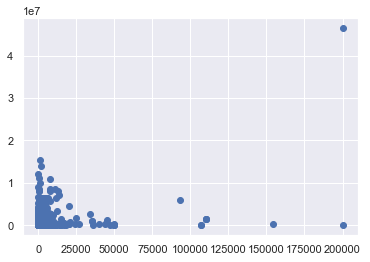

In [34]:
plt.scatter(x=df1[CAMPO_SUPERFICIE], y=df1['precio'])

Observamos las características de estos dos valores

In [35]:
df1['total_m2'] = df1['total_m2'].astype(float)

df1.loc[:,['total_m2','precio']].describe()

,total_m2,precio
count,82386.000000,6.938200e+04
mean,236.540005,2.501950e+05
std,1781.341396,3.919072e+05
min,1.000000,4.666620e+03
25%,50.000000,9.287686e+04
50%,84.000000,1.500000e+05
75%,200.000000,2.800000e+05
max,200000.000000,4.654544e+07


### Superficie de las propiedades
Encontramos outliers en total por m2. Para poder tratar correctamente estos, vamos a segmentarlos por ubicacion y tipo de propiedad y luego le aplicamos la media.
** Observamos la correlación entre precio y superficie cubierta antes de corregir los outliers **

(array([0.5, 1.5]), <a list of 2 Text xticklabel objects>)

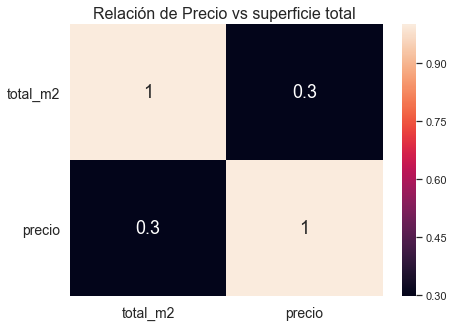

In [36]:
# Obtengo la correlación antes de eliminar outliers
df_corr_prev_outliers = df1[['total_m2','precio']].corr()

# Establezco el tamaño del plot
plt.figure(figsize=(7,5))
# Creo el heatmap
sns.heatmap(df_corr_prev_outliers, annot=True,annot_kws={"size": 18})
# Establezco el título
plt.title('Relación de Precio vs superficie total ', fontsize=16)
# Configuro los ejes.
plt.yticks(rotation=0, fontsize=14)
plt.xticks(fontsize=14)

**Eliminamos los outliers de superficie**

In [37]:
# Obtengo la media de las propiedades que tienen precio (price_aprox_usd no es nulo)
mean = df1.loc[~df1[CAMPO_SUPERFICIE].isnull(), CAMPO_SUPERFICIE].mean()
        
# Obtengo la desviacion estandar
std_dev = df1.loc[~df1[CAMPO_SUPERFICIE].isnull(), CAMPO_SUPERFICIE].std()
        
if ELIMINAR_OUTLIER_SUPERFICIES:
    # Si la media no es nulo
    if (~np.isnan(mean)):
        
            
        # Obtengo los outliers para el lugar y tipo de propiedad
        df_outliers = df1.loc[(np.abs(df1[CAMPO_SUPERFICIE] - mean) > 3 * std_dev)] # Que esten por encima o debajo de 3 desviaciones std.
            
        # Los elimino del dataframe original
        df1 = df1.drop(df_outliers.index)

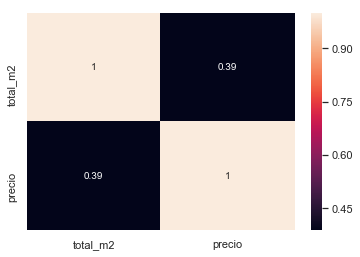

In [38]:
sns.heatmap(df1[[CAMPO_SUPERFICIE,'precio']].corr(), annot=True)

Observamos nuevamente la la correlación entre precio y superficie y encontramos que la correlación entre estas mejoró.

## Precio
Observamos outliers en precio y los precios por m2 en dolares lo que los eliminamos para que no formen parte del entrenamiento de nuestro modelo. 

In [39]:
# Obtengo la media de las propiedades que tienen precio (precio no es nula)
mean = df1.loc[~df1['precio_usd_por_m2'].isnull(), 'precio_usd_por_m2'].mean()

# Si la configuración lo especifíca, elimino los outliers de precio
if ELIMINAR_OUTLIER_PRECIOS:    
            
    # Si la media no es NaN
    if (~np.isnan(mean)):
        # Obtengo la desviacion estandar
        std_dev = df1.loc[~df1['precio_usd_por_m2'].isnull(), 'precio_usd_por_m2'].std()
            
        # Obtengo los outliers para el lugar y tipo de propiedad
        df_outliers = df1.loc[(np.abs(df1['precio_usd_por_m2'] - mean) > 3 * std_dev)] # Que esten por encima o debajo de 3 desviaciones std.
        
        # Los elimino del dataframe original
        df1 = df1.drop(df_outliers.index)

In [40]:
# Obtengo la media de las propiedades que tienen precio (precio no es nula)
mean = df1.loc[~df1['precio'].isnull(), 'precio'].mean()

# Si la configuración lo especifíca, elimino los outliers de precio
if ELIMINAR_OUTLIER_PRECIOS:    
            
    # Si la media no es NaN
    if (~np.isnan(mean)):
        # Obtengo la desviacion estandar
        std_dev = df1.loc[~df1['precio'].isnull(), 'precio'].std()
            
        # Obtengo los outliers para el lugar y tipo de propiedad
        df_outliers = df1.loc[(np.abs(df1['precio'] - mean) > 3 * std_dev)] # Que esten por encima o debajo de 3 desviaciones std.
        
        # Los elimino del dataframe original
        df1 = df1.drop(df_outliers.index)

** Observamos la correlación entre precio y superficie cubierta despues de corregir los outliers **

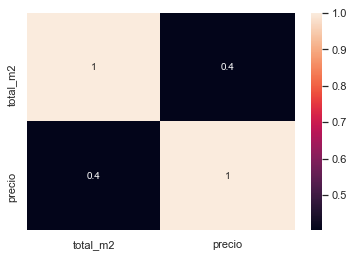

In [41]:
sns.heatmap(df1[[CAMPO_SUPERFICIE,'precio']].corr(), annot=True)

Veo que hay una mejora sustancial.

**Estructura final**
Puedo probar con predecir precio o precio por m2 en dolares. 
1. Precio m2 en dolares por lo que se puede ver siempre da correlación negativa contra la superficie. 
2. Precio su correlación es positiva. 
3. Primero prueba precio y en otra notebook precio por m2 en dolares y comparo

In [42]:
#set limpio sin nulos.
dfaux=df1
if PRECIO:
    #df1=df1.loc[df1.precio.notnull(),:]
    df1=df1.loc[df1.precio.notnull(),:]
    df1 = df1.drop('precio_usd_por_m2', axis=1)
else:
    #df1=df1.loc[df1.precio.notnull(),:]
    df1=df1.loc[df1.precio_usd_por_m2.notnull(),:]
    df1 = df1.drop('precio', axis=1)

In [43]:
datos_df(df1)

,No Nulos,Nulos,% Nulos,Tipo
tipo_propiedad,67155,0,0.0,object
precio,67155,0,0.0,float64
total_m2,67155,0,0.0,float64
habitaciones,67155,0,0.0,float64
superficie_era_null,67155,0,0.0,int64
habitaciones_was_nan,67155,0,0.0,int32
ubicacion,67155,0,0.0,object
m2_por_habitacion,67155,0,0.0,float64


# Generación del Modelo

## Definición de columnas a utilizar
###  Fit
Elegimos las columnas para la predicción:<br>
* habitaciones o m2_por_habitacion
* total_m2
* tipo_rpopiedad
* ubicacion

### Columna label
Esta columna la vamos a utilizar para indicar el valor de cada registro
* precio o precio_usd_por_m2

## Ciudades a predecir
Debido a que vamos a predecir valores de una colección específica de datos, solo nos interesa entrenar el modelo con las ciudades que estan dentro de los valores a predecir. El resto los eliminamos del dataset para tener una menor varianza.

In [44]:
# Cuento la cantidad de propiedades por ciudad. 
# Utilizo cualquier columna ya que me interesa el valor de filas y no el de alguna columna en particular
df_propiedades_por_ubicacion = df1[['ubicacion','tipo_propiedad']].groupby('ubicacion').count()

# Cambio el nombre de la columna para no confundir datos
df_propiedades_por_ubicacion = df_propiedades_por_ubicacion.rename(index=str,columns={'tipo_propiedad':'cant_props'})


# Obtengo los lugares que tienen una cantidad de propiedades mayor a la cantidad de columnas
ubicacion_por_modelo = df_propiedades_por_ubicacion.loc[df_propiedades_por_ubicacion['cant_props'] > len(df1.columns)]

# Dejamos solo las ciudades que tienen mas propiedades que características
modelo_df = df1.loc[df1['ubicacion'].isin(ubicacion_por_modelo.index)]

In [45]:
# Cuento la cantidad de propiedades por ciudad. 
# Utilizo cualquier columna ya que me interesa el valor de filas y no el de alguna columna en particular
df_propiedades_por_tipo = df1.groupby(['tipo_propiedad','ubicacion']).count()

## Normalizacion
**Normalizo los label con log1p**

In [46]:
from sklearn.preprocessing import FunctionTransformer

# Instancio con log1p
#transformer = FunctionTransformer(np.log1p)

# Obtengo los valores de precio como un array numpy
#precio = modelo_df['precio'].values

# Aplico la transformación y la asigno directamente a la columna de precio
#modelo_df['precio'] = transformer.transform([precio])[0]

## Normalizamos los X con MinMax o Standard Scaler

In [47]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

#Uso MinMax o StandardScaler
#minmaxscaler_model = StandardScaler()
minmaxscaler_model = MinMaxScaler()

# Columnas a normalizar
columnas= [CAMPO_SUPERFICIE]

# Si calcula superficie por ambiente y uso ROOMS
if CALCULAR_SUPERFICIE_POR_AMBIENTE & UTILIZAR_ROOMS:
    # También normalizar rooms por m2
    columnas.append('m2_por_habitacion')
    
elif UTILIZAR_ROOMS & (~CALCULAR_SUPERFICIE_POR_AMBIENTE):
    columnas.append('habitaciones')

# Aplico scaler a las columnas elegidas
modelo_df[columnas] = minmaxscaler_model.fit_transform(modelo_df[columnas])

C:\Users\mesayoni\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\mesayoni\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


##  Dummies
Convertimos las columnas categórias a columnas Dummy.

### Tipo de propiedad
Obtenemos las dummies de **tipo_propiedad**

In [48]:
# Obtenemos las columnas dummies de property_type
df_tipo_propiedad = pd.get_dummies(modelo_df['tipo_propiedad'], drop_first=True, prefix='tipo_propiedad')

# Agregamos las columnas dummies concatenando el dataframe original con las dummies
df_with_dummies = pd.concat([modelo_df, df_tipo_propiedad], axis=1)

# Eliminamos la columna tipo_propiedad del dataframe nuevo
df_with_dummies = df_with_dummies.drop('tipo_propiedad', axis=1)

### Ubicación
Obtenemos las dummies de **ubicacion** .

In [49]:
# Obtenemos la columna dummies de ubicacion
df_ubicacion = pd.get_dummies(modelo_df['ubicacion'], drop_first=True, prefix='ubicacion')
    
# Agreamos las columnas dummies concatenando el nuevo dataframe con las dummies
df_with_dummies = pd.concat([df_with_dummies, df_ubicacion], axis=1)
   
# Eliminamos la columna place_with_parent_names del nuevo dataframe
df_with_dummies = df_with_dummies.drop('ubicacion', axis=1)
    
# Guardamos el nombre de cada ubicacion en la variable ubicacion
ubicacion = df_ubicacion.columns


In [50]:
#guardo en una columna el valor de los indices para no perderlos
df_with_dummies['indices']=df_with_dummies.index

## Ubicacion x Superficie
Creamos otra colección de features mutiplicando la superficie de la propiedad * el lugar. Esto va a generar un $\beta$ distinto para cada propiedad, dependiendo del lugar donde está.

In [51]:
# Obtengo el array de numpy de Superficies
arr_superficie = modelo_df[CAMPO_SUPERFICIE].values

# La paso de 1 dimension a 2.
arr_superficie = arr_superficie[:, None]
    
# Calculo el producto de cada columna de lugar x la superficie para obtener una columna de superficie para cada lugar.
df_mul_ubicacion = pd.DataFrame(df_ubicacion.values * arr_superficie)
    
#df_mul_places.reset_index(drop=True, inplace=True)
df_with_dummies.reset_index(drop=True, inplace=True)
    
# Le agrego las nuevas columnas al dataframe
df_with_dummies = pd.concat( [df_with_dummies, df_mul_ubicacion], axis=1) 

## Tipo propiedad x Superficie
Creamos otra colección de features mutiplicando la superficie de la propiedad * el tipo de propiedad. Esto va a generar un $\beta$ distinto para cada propiedad, dependiendo del tipo de propiedad.

In [52]:
# Obtengo el array de numpy de Superficies
arr_superficie = modelo_df[CAMPO_SUPERFICIE].values 
    
# La paso de 1 dimension a 2.
arr_superficie = arr_superficie[:, None]
        
# Calculo el producto de cada columna de lugar x la superficie para obtener una columna de superficie para cada lugar.
df_mul_tipo_propiedad = pd.DataFrame(df_tipo_propiedad.values * arr_superficie)
    
#df_mul_property_type.reset_index(drop=True, inplace=True)
df_with_dummies.reset_index(drop=True, inplace=True)
    
# Le agrego las nuevas columnas al datafra,e
df_with_dummies = pd.concat( [df_with_dummies, df_mul_tipo_propiedad], axis=1) 

## Preparación de Features y Labels de Entrenamiento y Test
Utilizamos el modelo de Regresión Lineal y lo entrenamos con nuestros datos de entrenamiento

### Funciones
Separo los datos que tienen precio

In [53]:
def get_train_predict_sets(df):
    # Guardo las filas que tienen el precio en null
    if PRECIO:
        df_predict = df.loc[df['precio'].isnull()]
    else:
        df_predict = df.loc[df['precio_usd_por_m2'].isnull()]
    

    # Luego, elimino esas filas del dataframe original.
    df_train = df.drop(df_predict.index)
    
    return df_train, df_predict

In [54]:
def get_predict_sets(df):
    # Guardo las filas que tienen el precio en null
    if PRECIO:
        df_predict = df.drop('precio', axis=1)
        #df_predict = df.drop(df_predict.index)
    else:
        df_predict = df.drop('precio_usd_por_m2', axis=1)
        #df_predict = df.drop(df_predict.index)        

    return df_predict

**Valores y Labels**
Del dataframe, separamos nuestros labels de los valores a utilizar para entrenar

In [55]:
def get_features_labels(df):
    #Separa las features de los labels de un dataframe y los devuelve en el orden FEATURES, LABELS (X, Y)
    if PRECIO:
        # Obtengo los labels (precio)
        Y = df['precio']

        # Obtengo los valores sin los labels
        X = df.drop('precio', axis=1)
    else:
        # Obtengo los labels (precio)
        Y = df['precio_usd_por_m2']

        # Obtengo los valores sin los labels
        X = df.drop('precio_usd_por_m2', axis=1)
        
    
    
    return X, Y

### Holdout Sets
De nuestros datos de entrenamiento con labels conocidos, separamos un porcentaje con el cual entrenaremos el modelo, y otro porcentaje con el cual haremos la validación. Vamos a usar un 70% para el entrenamiento y un 30% para la validación.

In [56]:
# Utilizamos el método train_test_split de Scikit Learn para separar los datos
from sklearn.model_selection import train_test_split

def get_houldout_sets(X,Y, random_state, train_size):   
    
    # obtenemos X e Y de test y entrenamiento.
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=random_state, train_size=train_size)
    
    return X_train, X_test, Y_train, Y_test

## Entrenamiento y predicción de los valores test para TODAS las Zonas
Entrenamos el modelo con todos los valores y verificamos el score

### Cross Validation de Modelos

In [57]:
from sklearn.preprocessing import PolynomialFeatures
from scipy.sparse import csr_matrix

# Dataframe donde muestro los resultados
df_resultados = pd.DataFrame(columns=['Model', 'MSE', 'R^2', 'Alpha'])

# Obtengo los dataframe de train y predict
df_train, df_predict = get_train_predict_sets(df_with_dummies)

# Obtengo los features y labels por separado
X, Y = get_features_labels(df_train)

#X = PolynomialFeatures().fit_transform(X)


# Obtengo los sets de entrenamiento y de test con un 70% de valores de entrenamiento (30% de test)
X_train, X_test, Y_train, Y_test = get_houldout_sets(X, Y, random_state=1, train_size=0.70)

C:\Users\mesayoni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Cantidad de registros

In [58]:
print('Se entrenarán a los modelos con ',len(X_train),'registros')

Se entrenarán a los modelos con  46024 registros


### Regresion lineal

In [59]:
# Importamos librerias de scikit learn
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Instancio el modelo
lin_model = linear_model.LinearRegression()
# Fiteo el modelo
lin_model.fit(X_train, Y_train)
# Predigo los valores 
Y_predicted_linear = lin_model.predict(X_test)
# Ejecuto una cross validation de 5 folds
mse_score_linear = cross_val_score(lin_model, X, Y, cv=10, scoring='neg_mean_squared_error') * -1
r2_score_linear = cross_val_score(lin_model, X, Y, cv=10)


# Agrego los resultados al dataframe de resultados
row = {'Model':'Linear Regression', 'MSE': mse_score_linear.mean(), 'R^2': r2_score_linear.mean(), 'Alpha': 0, 'Cant. Cols.': len(X_train.columns)}
df_resultados = df_resultados.append(row, ignore_index=True)

# Muestro los resultados
df_resultados

,Model,MSE,R^2,Alpha,Cant. Cols.
0,Linear Regression,1.581126e+10,0.496029,0,720.0


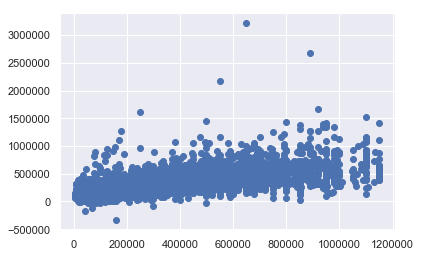

In [60]:
plt.scatter(x=Y_test, y =Y_predicted_linear)

### Ridge

In [61]:
# Instancio el modelo
ridge_model = linear_model.RidgeCV(cv=10)
# Fiteo el modelo
ridge_model_fitted = ridge_model.fit(X_train, Y_train)
# Predigo los valores 
Y_predicted_ridge = ridge_model_fitted.predict(X_test)
# Obtengo el score R2
r2_score_ridge = ridge_model_fitted.score(X, Y)
# Obtengo el MSE
mse_score_ridge = mean_squared_error(Y_test, Y_predicted_ridge)


# Agrego los resultados al dataframe de resultados
row = {'Model':'Ridge', 'MSE': mse_score_ridge.mean(), 'R^2': r2_score_ridge.mean(), 'Alpha': ridge_model_fitted.alpha_, 'Cant. Cols.': len(X_train.columns)}
df_resultados = df_resultados.append(row, ignore_index=True)

# Muestro los resultados
df_resultados

,Model,MSE,R^2,Alpha,Cant. Cols.
0,Linear Regression,1.581126e+10,0.496029,0,720.0
1,Ridge,1.421447e+10,0.561553,1,720.0


Text(0.5, 0, 'Valores Reales (con scale)')

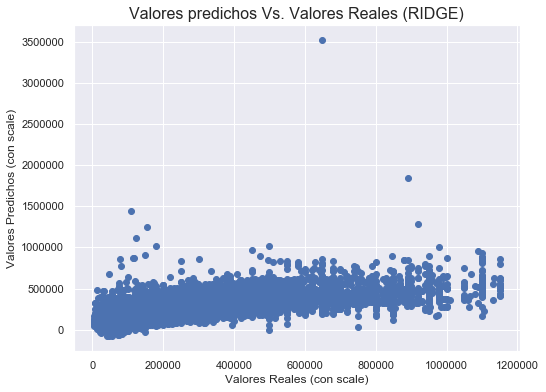

In [62]:
plt.figure(figsize=(8,6))
plt.scatter(x=Y_test, y =Y_predicted_ridge)
plt.title('Valores predichos Vs. Valores Reales (RIDGE)', fontsize=16)
plt.ylabel('Valores Predichos (con scale)')
plt.xlabel('Valores Reales (con scale)')

### Lasso

In [63]:
#np.linspace(0, 1, 100, endpoint=True)

In [64]:
# Instancio el modelo
#alpha=np.linspace(0.01,1)
lasso_model = linear_model.LassoCV(cv=10,max_iter=2000)
#Fiteo el modelo
lasso_model_fitted = lasso_model.fit(X_train,Y_train)
# Predigo los datos
Y_predicted_lasso = lasso_model_fitted.predict(X_test)
# Obtengo el score R2
r2_score_lasso = lasso_model_fitted.score(X, Y)
# Obtengo el MSE
mse_score_lasso = mean_squared_error(Y_test, Y_predicted_lasso)

# Agrego los resultados al dataframe de resultados
row = {'Model':'Lasso', 'MSE': mse_score_lasso.mean(), 'R^2':r2_score_lasso.mean(), 'Alpha': lasso_model_fitted.alpha_, 'Cant. Cols.': len(X_train.columns)}
df_resultados = df_resultados.append(row, ignore_index=True)

# Muestro los resultados
df_resultados

,Model,MSE,R^2,Alpha,Cant. Cols.
0,Linear Regression,1.581126e+10,0.496029,0,720.0
1,Ridge,1.421447e+10,0.561553,1,720.0
2,Lasso,3.155169e+10,0.002627,315039,720.0


## Elimino las columnas cuyos coeficientes son cero y pruebo nuevamente
Eliminamos las columnas cuyos coeficientes son cero y luego ejecutamos Lasso nuevamente pero guardo una copia del X original para poder aplicarlo a una muestra de 100 luego.

In [65]:
# Guardo el X original y elimino las columnas de X cuyos coeficientes son 0 (cero)
X = X[X.columns[np.nonzero(lasso_model_fitted.coef_)]]

# Obtengo el test split
X_train, X_test, Y_train, Y_test = get_houldout_sets(X, Y, random_state=1, train_size=0.70)

C:\Users\mesayoni\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Lasso nuevamente con coeficientes sin cero

In [66]:
# Instancio el modelo
lasso_model = linear_model.LassoCV(cv=10,max_iter=2000)
#Fiteo el modelo
lasso_model_fitted = lasso_model.fit(X_train,Y_train)
# Predigo los datos
Y_predicted_lasso = lasso_model_fitted.predict(X_test)
# Obtengo el score R2
r2_score_lasso = lasso_model_fitted.score(X, Y)
# Obtengo el MSE
mse_score_lasso = mean_squared_error(Y_test, Y_predicted_lasso)

# Agrego los resultados al dataframe de resultados
row = {'Model':'Lasso sin coef 0', 'MSE': mse_score_lasso.mean(), 'R^2':r2_score_lasso.mean(), 'Alpha': lasso_model_fitted.alpha_, 'Cant. Cols.': len(X_train.columns)}
df_resultados = df_resultados.append(row, ignore_index=True)

# Muestro los resultados
df_resultados

,Model,MSE,R^2,Alpha,Cant. Cols.
0,Linear Regression,1.581126e+10,0.496029,0,720.0
1,Ridge,1.421447e+10,0.561553,1,720.0
2,Lasso,3.155169e+10,0.002627,315039,720.0
3,Lasso sin coef 0,3.155169e+10,0.002627,315039,1.0


Text(0.5, 0, 'Valores Reales (con scale)')

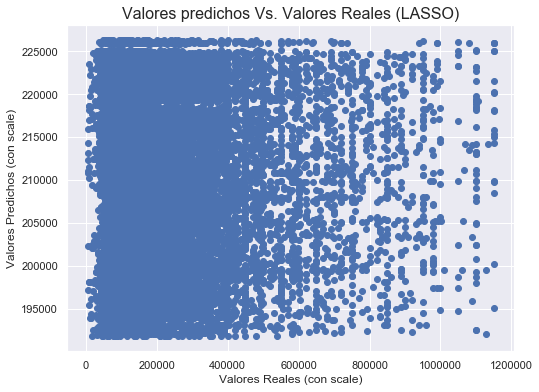

In [67]:
plt.figure(figsize=(8,6))
plt.scatter(x=Y_test, y =Y_predicted_lasso)
plt.title('Valores predichos Vs. Valores Reales (LASSO)', fontsize=16)
plt.ylabel('Valores Predichos (con scale)')
plt.xlabel('Valores Reales (con scale)')

### DataFrame con los resultados
Armamos un dataframe que contenga los resultados predichos en cada modelo

In [68]:
#  Me guardo los indices originales para poder identificar luego cada fila
y_index = Y_test.index
# Reinicio los indices para poder unir los Y de tes ty los Y predichos
Y_test_indexless = Y_test.reset_index(drop=True)

# Concateno los Y de todos los modelos
Y_values = pd.DataFrame({'y_real': Y_test_indexless, 'y_linear': Y_predicted_linear ,'y_ridge': Y_predicted_ridge, 'y_lasso': Y_predicted_lasso})

#pd.Series(Y_predicted_ridge).describe()
# Le asigno el nombre a las columnas
#Y_values.columns = ['Y Real','Y Predicted Linear','Y Predicted Ridge', 'Y Predicted Lasso',]

### Outliers en las predicciones
Encontramos que hay algunos outliers en las predicciones.<br>
Vamos a observar los resultados eliminandolos. Para esto debemos realizar varios pasos para asignar los valores predichos al dataframe original.

In [69]:
# Elimino los outliers de los valores predichos de cada modelo
df_result_sin_outliers_lasso = Y_values[np.abs(Y_values['y_lasso']-Y_values['y_lasso'].mean())<=(3*Y_values['y_lasso'].std())].copy()
df_result_sin_outliers_ridge = Y_values[np.abs(Y_values['y_ridge']-Y_values['y_ridge'].mean())<=(3*Y_values['y_ridge'].std())].copy()
df_result_sin_outliers_linear = Y_values[np.abs(Y_values['y_linear']-Y_values['y_linear'].mean())<=(3*Y_values['y_linear'].std())].copy()

# Por ultimo agrego una nueva columna con la diferencia entre lo predicho y lo real
df_result_sin_outliers_lasso['result_dif'] = df_result_sin_outliers_lasso['y_real']-df_result_sin_outliers_lasso['y_lasso']
df_result_sin_outliers_ridge['result_dif'] = df_result_sin_outliers_ridge['y_real']-df_result_sin_outliers_ridge['y_ridge']
df_result_sin_outliers_linear['result_dif'] = df_result_sin_outliers_linear['y_real']-df_result_sin_outliers_linear['y_linear']

### Graficamos los resultados sin los outliers de las predicciones

C:\Users\mesayoni\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Valores Reales')

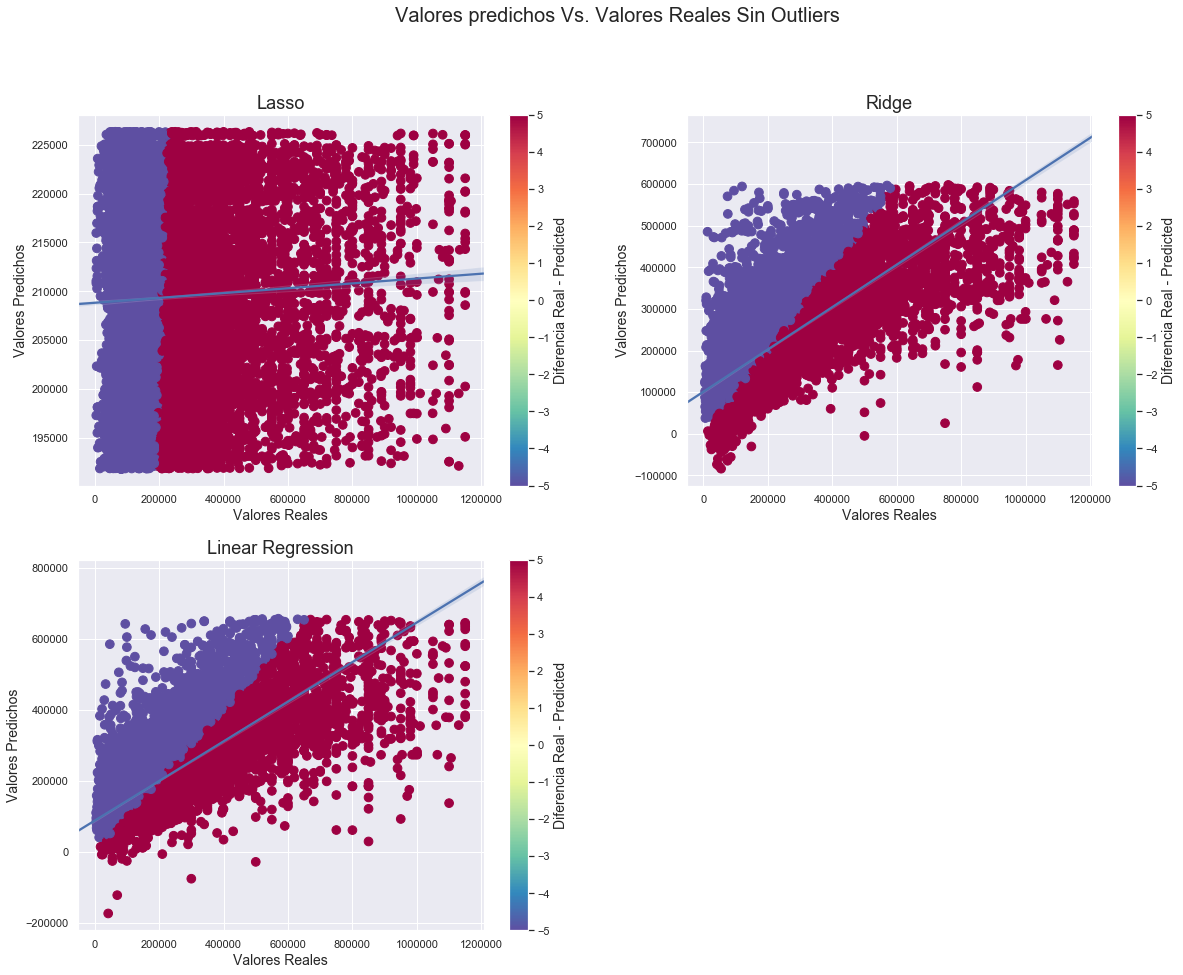

In [70]:
# Grafico los valores de Y sin outliers
plt.figure(figsize=(20,15))

# Defino los ticks con los valores de las colorbar
colorbar_ticks = [-5,-4,-3,-2,-1,0,1,2,3,4,5]

# LASSO
plt.subplot(2,2,1)

# Scatter
points = plt.scatter(x=df_result_sin_outliers_lasso['y_real'], y=df_result_sin_outliers_lasso['y_lasso'],c=df_result_sin_outliers_lasso['result_dif'], s=75, cmap="Spectral_r", vmin=-5, vmax=5)
# Colorbar

clbr = plt.colorbar(ticks=colorbar_ticks)
clbr.set_label('Diferencia Real - Predicted', fontsize=14)

# Regression
ax1 = sns.regplot(x="y_real", y="y_lasso", data=df_result_sin_outliers_lasso, scatter=False,)
# Establezco los títulos
plt.title('Lasso', fontsize=18)
plt.ylabel('Valores Predichos', fontsize=14)
plt.xlabel('Valores Reales',fontsize=14)

# RIDGE
plt.subplot(2,2,2)

# Scatter
points = plt.scatter(x=df_result_sin_outliers_ridge['y_real'], y=df_result_sin_outliers_ridge['y_ridge'],c=df_result_sin_outliers_ridge['result_dif'], s=75, cmap="Spectral_r", vmin=-5, vmax=5)
# Colorbar
#clbr = plt.colorbar(points)
clbr = plt.colorbar(ticks=colorbar_ticks)
clbr.set_label('Diferencia Real - Predicted', fontsize=14)
# Regression
sns.regplot(x="y_real", y="y_ridge", data=df_result_sin_outliers_ridge, scatter=False)
# Establezco los títulos
plt.suptitle('Valores predichos Vs. Valores Reales', fontsize=20)
plt.title('Ridge', fontsize=18)
plt.ylabel('Valores Predichos', fontsize=14)
plt.xlabel('Valores Reales',fontsize=14)

# LINEAR
plt.subplot(2,2,3)

# Scatter
points = plt.scatter(x=df_result_sin_outliers_linear['y_real'], y=df_result_sin_outliers_linear['y_linear'],c=df_result_sin_outliers_linear['result_dif'], s=75, cmap="Spectral_r", vmin=-5, vmax=5)
# Colorbar
clbr = plt.colorbar(ticks=colorbar_ticks)
clbr.set_label('Diferencia Real - Predicted', fontsize=14)
# Regression
sns.regplot(x="y_real", y="y_linear", data=df_result_sin_outliers_linear, scatter=False)
# Establezco los títulos
plt.suptitle('Valores predichos Vs. Valores Reales Sin Outliers', fontsize=20)
plt.title('Linear Regression', fontsize=18)
plt.ylabel('Valores Predichos', fontsize=14)
plt.xlabel('Valores Reales',fontsize=14)


In [71]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df_result_sin_outliers_ridge.describe()

,y_real,y_linear,y_ridge,y_lasso,result_dif
count,19504.000,19504.000,19504.000,19504.000,19504.000
mean,203312.312,203428.108,204372.665,209294.924,-1060.353
std,168004.895,127977.531,115263.820,9538.005,113294.587
min,5047.530,-341418.692,-83760.949,191841.577,-495420.209
25%,90761.223,108875.249,112769.101,201095.675,-56185.190
50%,145000.000,174101.354,186953.302,209515.399,-11986.787
75%,255000.000,264412.714,271936.480,217388.292,27656.158
max,1150000.000,1440588.763,597804.405,226337.914,934959.184


**Eligo una muestra 100 del dataset usado originalmente**
Es el que tiene las dummies

In [72]:
df1_muestra = get_predict_sets(df_with_dummies)

#df1_muestra['prediccion']=lasso_model_fitted.predict( df1_muestra[X.columns[np.nonzero(lasso_model_fitted.coef_)]])
#df1_muestra['prediccion']=ridge_model_fitted.predict( df1_muestra[X.columns])
#df1_muestra[X.columns].head()

In [73]:
df1_muestra['prediccion']=ridge_model_fitted.predict(df1_muestra)

In [74]:
df_resul=pd.merge(df1_muestra[['prediccion','indices']],dfaux, how='left', left_on=['indices'], right_index=True)

In [84]:
muestra=df_resul.sample(100)
muestra['precio'].sum()

22718201.44

In [75]:
df_resul['diferencia'] = df_resul['precio'] - df_resul['prediccion']

In [83]:
df_resul.loc[(df_resul['diferencia']>-1000) & (df_resul['diferencia']<1000), ['precio','prediccion','ubicacion','tipo_propiedad','diferencia']].sort_values(by=['diferencia'])

,precio,prediccion,ubicacion,tipo_propiedad,diferencia
45638,48792.790,49790.139,Santa Fe-Rosario,apartment,-997.349
63561,117500.000,118490.633,Capital Federal-Villa Urquiza,apartment,-990.633
56418,44306.100,45295.376,Santa Fe-Rosario,apartment,-989.276
56376,44306.100,45290.543,Santa Fe-Rosario,apartment,-984.443
43704,102215.020,103199.064,Capital Federal-Villa Luro,apartment,-984.044
16095,76000.000,76981.999,Capital Federal-Almagro,apartment,-981.999
3801,298000.000,298976.258,Bs.As. G.B.A. Zona Norte-Tigre,house,-976.258
3800,298000.000,298976.179,Bs.As. G.B.A. Zona Norte-Tigre,house,-976.179
4550,480000.000,480974.637,Bs.As. G.B.A. Zona Norte-San Isidro,house,-974.637
4549,480000.000,480974.557,Bs.As. G.B.A. Zona Norte-San Isidro,house,-974.557
